In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import xarray as xr
import fnmatch
import numpy as np
import os
import keras
from surgeNN.io import load_predictand,load_predictors
from surgeNN.preprocessing import get_denseloss_weights,split_predictand_and_predictors_chronological,split_predictand_and_predictors_stratified_years
from surgeNN.preprocessing import generate_batched_windowed_filtered_tf_input, generate_windowed_filtered_np_input, deseasonalize_da, deseasonalize_df_var, bandstop_filter_hourly_predictand
from surgeNN.evaluation import compute_statistics_on_output_ds,rmse
from surgeNN.preprocessing import stack_predictors_for_lstm, stack_predictors_for_convlstm, normalize_predictand_splits, normalize_predictor_splits,standardize_predictand_splits, standardize_predictor_splits
from surgeNN.models import build_LSTM_stacked, build_ConvLSTM2D_with_channels
from surgeNN.losses import gevl,exp_negexp_mse,obs_squared_weighted_mse, obs_weighted_mse
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from target_relevance import TargetRelevance #if starting with a clean environment, first, in terminal, do->'mamba install kdepy'

import gc #callback to clean up garbage after each epoch, not sure if needed (usage: callbacks = [GC_Callback()])
class GC_Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        
#for using a decaying learning rate        
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.exp(-0.1)

lr_callback = keras.callbacks.LearningRateScheduler(scheduler)

2024-09-11 09:40:16.838767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Configure the script:

In [2]:
tgs        = ['barcelona-bar-esp-cmems.csv','den_helder-denhdr-nld-rws.csv', 'brest-822a-fra-uhslc.csv', 
            'immingham-imm-gbr-bodc.csv','stavanger-svg-nor-nhs.csv'] #tide gauges to process
tgs = ['den_helder-denhdr-nld-rws.csv']
temp_freq = 3 # [hours] temporal frequency to use
n_cells   = 5 #n x n grid cells around tide gauge of predictor data to use

var_names = ['msl','u10','v10','w'] #variables to use

loss_function = 'DenseLoss_mse' # any default loss function or 'DenseLoss_[default loss function]' or 'gevl'
#loss_function = 'mse'
gevl_gamma = 1 #gevl gamma parameter, vary between 1-3? (not used if not using loss function)
exp_a=1 #+/- ratio exp negexp loss function
exp_t=2 #temperature in exponentials exp negexp loss function

architecture = 'lstm'

input_dir  = '/home/jovyan/test_surge_models/input/' #directory with predictor & predictand data
output_dir = os.path.join('/home/jovyan/test_surge_models/results/nn_tests/',architecture+'/') #where to store the results

n_runs = 18 #how many iterations with different hyperparameter combinations to run
n_iterations = 1
n_epochs = 100 #how many training epochs
patience = 10 #early stopping patience

split_fractions = [.6,.2,.2] #train, test, val
split_method = '99pct'
split_start_month = 7
split_seed = 0

#hyperparameters:
dl_alpha = np.array([1,3,5]).astype('int')
batch_size = np.array([128]).astype('int')
n_steps = np.array([9]).astype('int') #at and 12h or 24h or 36h before (to-do: also use timesteps after?)
n_convlstm = np.array([1]).astype('int')
n_convlstm_units = np.array([32]).astype('int')
n_dense = np.array([2]).astype('int')
n_dense_units = np.array([32]).astype('int')
dropout = np.array([0.1,0.25])
lrs = np.array([1e-5,5e-5,1e-4])
l1s = np.array([0.02])
'''

#hyperparameters (1 option per parameter):
dl_alpha = np.array([3]).astype('int')
batch_size = np.array([128]).astype('int')
n_steps = np.array([9]).astype('int') #at and 12h or 24h or 36h before (to-do: also use timesteps after?)
n_convlstm = np.array([1]).astype('int')
n_convlstm_units = np.array([32]).astype('int')
n_dense = np.array([2]).astype('int')
n_dense_units = np.array([32]).astype('int')
dropout = np.array([0.1])
lrs = np.array([1e-5])
l1s = np.array([0.02])
'''
possible_params = [batch_size, n_steps, n_convlstm, n_convlstm_units,
                    n_dense, n_dense_units, dropout, lrs, l1s, dl_alpha]

n_combinations = np.prod(np.array([len(k) for k in possible_params])) #number of unique combinations possible

Determine loss function to use:

In [3]:
#determine loss function to use
use_dl = False

if loss_function.split('_')[0] == 'DenseLoss':
    use_dl = True
    loss_function_ = loss_function.replace('DenseLoss_','')
    print('Will use DenseLoss sample weights.')
else:
    loss_function_ = loss_function
    
if loss_function_ == 'gevl':
    loss_function_ = gevl(gevl_gamma)
elif loss_function =='mse_exp':
    loss_function_ = exp_negexp_mse(exp_a,exp_t)
elif loss_function_ == 'obs_squared_weighted_mse':
    loss_function_ = obs_squared_weighted_mse
elif loss_function_ == 'obs_weighted_mse':
    loss_function_ = obs_weighted_mse

print('Loss function: ')
print(loss_function_)

Will use DenseLoss sample weights.
Loss function: 
mse


Load in & preprocess data:

In [4]:
tg_lons = []
tg_lats = []

for tg in tqdm(tgs): #loop over TGs
    #load & process predictors
    #predictors = load_predictors('/home/jovyan/test_surge_models/input/predictors_'+str(temp_freq)+'hourly',tg,n_cells) #open predictor xarray data
    predictors = load_predictors('gs://leap-persistent/timh37/era5_predictors/'+str(temp_freq)+'hourly',tg,n_cells) #open predictor xarray data
    predictors = predictors.sel(time=slice('1979','2017')) #2018 because of end year GTSM simulations that are used as benchmark

    if 'w' in var_names and 'w' not in predictors.variables:
        predictors['w'] == np.sqrt((predictors.u10**2+predictors.v10**2))
        
    for var in var_names: #remove amean
        predictors[var] = predictors[var].groupby(predictors.time.dt.year) - predictors[var].groupby(predictors.time.dt.year).mean('time') #remove annual means
        predictors[var] = deseasonalize_da(predictors[var]) #remove mean seasonal cycle

    #load & process predictands
    
    #----test bandstop filter----
    #predictand = load_predictand('/home/jovyan/test_surge_models/input/t_tide_'+str(1)+'h_anoms_deseasoned_predictands',tg) #open predictand csv
    predictand = load_predictand('/home/jovyan/test_surge_models/input/t_tide_'+str(temp_freq)+'h_anoms_deseasoned_predictands',tg) #open predictand csv
    
    predictand = predictand[(predictand['date']>=predictors.time.isel(time=0).values) & (predictand['date']<=predictors.time.isel(time=-1).values)]  # only use predictands in the period for which we also have predictor values, including at preceding timesteps
    predictand = deseasonalize_df_var(predictand,'surge','date') #remove mean seasonal cycle
    
    #fill missing values before computing filter
    #predictand = bandstop_filter_hourly_predictand(predictand,30,265,345,10)
    #----test bandstop filter----
    
    predictand = predictand.set_index('date').resample(str(temp_freq)+'h').fillna(method=None) #insert nans where timesteps are missing
    predictand = predictand.reset_index()[['surge','date','lon','lat']]
    #predictand['surge'] = predictand['surge'].rolling(window=int(12/temp_freq+1),min_periods=int(12/temp_freq+1),center=True).mean() #crude way to filter out peaks due to uncorrected tides (Tiggeloven et al., 2021)
  
    #train & evaluate models n_iterations * n_runs times:
    for it in np.arange(n_iterations):
        tg_datasets = [] #list to store output
        all_params = [] #list of hyperparameters
        for i in tqdm(np.arange(n_runs if n_runs < n_combinations else n_combinations)): #loop over hyperparameter combinations

            #randomly select unique combinations of hyperparameters
            k=True 
            while k == True:
                these_params = [np.random.choice(k) for k in possible_params] 
                if these_params in all_params:
                    k = True
                else:
                    k = False
                    all_params.append(these_params) #keep track of hyperparameter combinations

            this_batch_size,this_n_steps,this_n_convlstm,this_n_convlstm_units,this_n_dense,this_n_dense_units,this_dropout,this_lr,this_l2,this_dl_alpha = these_params

            #generate splits
            #idx_train,idx_val,idx_test,x_train,x_val,x_test,y_train,y_val,y_test = split_predictand_and_predictors_chronological(predictand,predictors,split_fractions,this_n_steps)
            idx_train,idx_val,idx_test,x_train,x_val,x_test,y_train,y_val,y_test = split_predictand_and_predictors_stratified_years(predictand,predictors,
                                                                                                                                    split_fractions,this_n_steps,split_start_month,seed=split_seed,how=split_method)

            #standardize the input based on the mean & sd of the train split
            y_train,y_val,y_test,y_train_mean,y_train_sd = standardize_predictand_splits(y_train,y_val,y_test,output_transform = True)
            x_train,x_val,x_test = standardize_predictor_splits(x_train,x_val,x_test)

            if architecture == 'convlstm':
                x_train, x_val, x_test = [stack_predictors_for_convlstm(k,var_names) for k in [x_train,x_val,x_test]] #stack all predictor variables at each grid cell for LSTM input
            elif architecture == 'lstm':
                x_train, x_val, x_test = [stack_predictors_for_lstm(k,var_names) for k in [x_train,x_val,x_test]] #stack all predictor variables at each grid cell for LSTM input

            #get Denseloss weights
            w_train,w_val = [get_denseloss_weights(k, alpha = this_dl_alpha ) for k in [y_train,y_val]] #generate DenseLoss weights for train & val splits   

            #get values & timestamps of observations to compare predictions with
            t_train = predictand['date'].values[idx_train][np.isfinite(y_train)]
            t_val = predictand['date'].values[idx_val][np.isfinite(y_val)]
            t_test = predictand['date'].values[idx_test][np.isfinite(y_test)]

            #get windowed predictors & filter rows with nan observations from inputs (for tensorflow pipeline (to handle out-of-memory windowed predictors) see code below)
            x_train,y_train,w_train = generate_windowed_filtered_np_input(x_train,y_train,this_n_steps,w_train)
            x_val,y_val,w_val = generate_windowed_filtered_np_input(x_val,y_val,this_n_steps,w_val)
            x_test,y_test = generate_windowed_filtered_np_input(x_test,y_test,this_n_steps)

            o_train,o_val,o_test = [y_train_sd * k + y_train_mean for k in [y_train,y_val,y_test]] #back-transform observations

            #build model
            if architecture == 'convlstm':
                model = build_ConvLSTM2D_with_channels(this_n_convlstm, this_n_dense,
                                                       (np.ones(this_n_convlstm)*this_n_convlstm_units).astype(int), 
                                          (np.ones(this_n_dense)*this_n_dense_units).astype(int),
                                          this_n_steps,int(n_cells/0.25),int(n_cells/0.25),len(var_names), 'convlstm0',
                                                       this_dropout, this_lr, loss_function_,l2=this_l2)
            elif architecture == 'lstm':
                model = build_LSTM_stacked(this_n_convlstm, this_n_dense, 
                                  (np.ones(this_n_convlstm)*this_n_convlstm_units).astype(int), 
                                  (np.ones(this_n_dense)*this_n_dense_units).astype(int), 
                                   this_n_steps,int(n_cells/0.25),int(n_cells/0.25),len(var_names), 'lstm0',
                                   this_dropout, this_lr, loss_function_,l2=this_l2) #loss_function

            #train model:
            if use_dl: #if using DenseLoss weights
                train_history = model.fit(x=x_train,y=y_train,epochs=n_epochs,batch_size=this_batch_size,sample_weight=w_train,validation_data=(x_val,y_val,w_val),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience,
                                    restore_best_weights=True),GC_Callback()],verbose=2) #with numpy arrays input
            else: #else
                train_history = model.fit(x=x_train,y=y_train,epochs=n_epochs,batch_size=this_batch_size,validation_data=(x_val,y_val),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience,
                                    restore_best_weights=True),GC_Callback()],verbose=2) #with numpy arrays input

            #make predictions & back-transform
            yhat_train = model.predict(x_train,verbose=0).flatten()*y_train_sd + y_train_mean
            yhat_val = model.predict(x_val,verbose=0).flatten()*y_train_sd + y_train_mean
            yhat_test = model.predict(x_test,verbose=0).flatten()*y_train_sd + y_train_mean

            #store results into xr dataset for current i-j
            ds_train = xr.Dataset(data_vars=dict(o=(["time"], o_train),yhat=(["time"], yhat_train),hyperparameters=(['p'],these_params),),
            coords=dict(time=t_train,p=['batch_size', 'n_steps', 'n_convlstm', 'n_convlstm_units','n_dense', 'n_dense_units', 'dropout', 'lr', 'l2','dl_alpha'],),
            attrs=dict(description="ConvLSTM - neural network prediction performance.",loss_function=loss_function),)

            ds_val = xr.Dataset(data_vars=dict(o=(["time"], o_val),yhat=(["time"], yhat_val),hyperparameters=(['p'],these_params),),
            coords=dict(time=t_val,p=['batch_size', 'n_steps', 'n_convlstm', 'n_convlstm_units','n_dense', 'n_dense_units', 'dropout', 'lr', 'l2','dl_alpha'],),
            attrs=dict(description="ConvLSTM - neural network prediction performance.",loss_function=loss_function),)

            ds_test = xr.Dataset(data_vars=dict(o=(["time"], o_test),yhat=(["time"], yhat_test),hyperparameters=(['p'],these_params),),
            coords=dict(time=t_test,p=['batch_size', 'n_steps', 'n_convlstm', 'n_convlstm_units','n_dense', 'n_dense_units', 'dropout', 'lr', 'l2','dl_alpha'],),
            attrs=dict(description="ConvLSTM - neural network prediction performance.",loss_function=loss_function),)

            ds_i = xr.concat((ds_train,ds_val,ds_test),dim='split',coords='different') #concatenate results for each split
            ds_i = ds_i.assign_coords(split = ['train','val','test'])

            loss = np.nan*np.zeros(n_epochs) #add loss of training
            val_loss = np.nan*np.zeros(n_epochs)

            loss[0:len(train_history.history['loss'])] = train_history.history['loss']
            val_loss[0:len(train_history.history['val_loss'])] = train_history.history['val_loss']

            ds_i['loss'] = (['e'],loss)
            ds_i['val_loss'] = (['e'],val_loss)

            tg_datasets.append(ds_i) #append output of current iteration to list of all outputs

            del model, train_history, ds_i #, x_train, x_val, x_test
            tf.keras.backend.clear_session()
            gc.collect()

        #concatenate across runs & compute statistics
        out_ds = xr.concat(tg_datasets,dim='i',coords='different')
        out_ds = compute_statistics_on_output_ds(out_ds,[.95,.98,.99,.995])

        out_ds = out_ds.assign_coords(tg = np.array([tg]))
        out_ds = out_ds.assign_coords(lon = ('tg',np.array([predictand['lon'].values[0]])))
        out_ds = out_ds.assign_coords(lat = ('tg',np.array([predictand['lat'].values[0]])))

        out_ds.attrs['temp_freq'] = temp_freq
        out_ds.attrs['n_cells'] = n_cells
        out_ds.attrs['n_epochs'] = n_epochs
        out_ds.attrs['patience'] = patience
        out_ds.attrs['loss_function'] = loss_function
        out_ds.attrs['split_fractions'] = split_fractions
        out_ds.attrs['split_method'] = split_method+'_'+str(split_start_month)+'_'+str(split_seed)

        out_fn = architecture+'_'+str(temp_freq)+'h_'+tg.replace('.csv','')+'_'+loss_function+'_hp1_it'
        #out_ds.to_netcdf(os.path.join(output_dir,out_fn+str(len(fnmatch.filter(os.listdir(output_dir),out_fn+'*')))+'bsfilter.nc'),mode='w')

        #out_ds.to_netcdf(os.path.join(output_dir,architecture+'_'+str(temp_freq)+'h_lossfunc_test_'+tg.replace('.csv','')+'_'+loss_function.replace('DenseLoss','DenseLoss'+str(alpha)).replace('gevl','gevl'+str(gamma)).replace('mse_exp','mse_exp'+str(a)+'_'+str(t))+'10it.nc'),mode='w')
        #out_ds.to_netcdf(os.path.join(output_dir,'lstm_lossfunc_test_'+tg.replace('.csv','')+'_'+loss_function.replace('DenseLoss','DenseLoss'+str(alpha)).replace('gevl','gevl'+str(gamma))+'.nc'),mode='w')


  0%|          | 0/1 [00:47<?, ?it/s]


KeyboardInterrupt: 

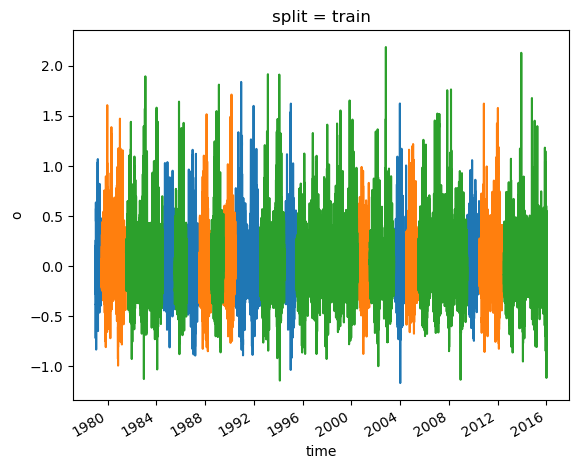

In [5]:
out_ds.o.sel(split='test').isel(i=0).plot()
out_ds.o.sel(split='val').isel(i=0).plot()
out_ds.o.sel(split='train').isel(i=0).plot()

array([[1.        , 0.14989953],
       [0.14989953, 1.        ]])

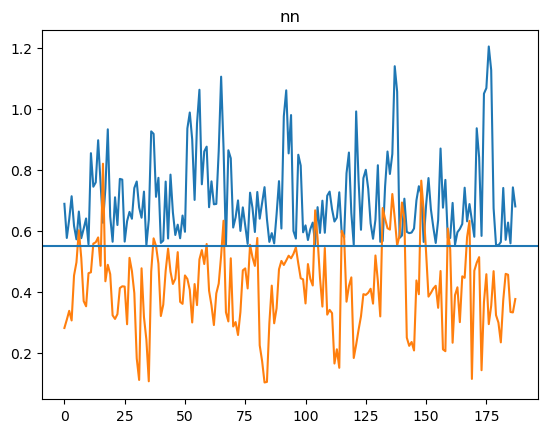

In [8]:
split='test'
i=np.argmin(out_ds.rmse_extremes.sel(split='val').isel(quantile=-1).values)
tr = out_ds.o.sel(split=split).isel(i=i).quantile(.99,dim='time')
plt.plot(out_ds.o.sel(split=split).where(out_ds.o.sel(split=split)>tr,drop=True).isel(i=i).values)
plt.plot(out_ds.yhat.sel(split=split).where(out_ds.o.sel(split=split)>tr,drop=True).isel(i=i).values)
plt.axhline(y=tr)

plt.title('nn')
rmse(out_ds.o.sel(split=split).where(out_ds.o.sel(split=split)>tr,drop=True).isel(i=i).values,out_ds.yhat.sel(split=split).where(out_ds.o.sel(split=split)>tr,drop=True).isel(i=i).values)
np.corrcoef(out_ds.o.sel(split=split).where(out_ds.o.sel(split=split)>tr,drop=True).isel(i=i).values,out_ds.yhat.sel(split=split).where(out_ds.o.sel(split=split)>tr,drop=True).isel(i=i).values)


In [10]:
threshold_pct=.99
threshold_value = out_ds.o.isel(i=0).sel(split='test').quantile(threshold_pct,dim='time').values

y_true = out_ds.o.isel(i=0).sel(split='test')#.resample(time='1D')#.dropna(dim='time')

surge_codec = xr.open_dataset('/home/jovyan/test_surge_models/CoDEC_ERA5_at_gesla3_tgs_eu_hourly_anoms.nc')
surge_codec['surge'] = deseasonalize_da(surge_codec['surge'])
surge_codec = surge_codec.sel(tg=tg).sel(time=out_ds.time.where(np.isfinite(y_true),drop=True))

#surge_codec['surge'] = surge_codec['surge'].rolling(time=int(12/temp_freq+1),min_periods=1,center=True).mean()
surge_codec = surge_codec#.resample(time='1D').max(skipna=True)
#surge_codec['surge'] = (surge_codec['surge'] - surge_codec['surge'].mean(dim='time'))/surge_codec['surge'].std(dim='time',ddof=0) #normalize
#surge_codec_test=surge_codec.surge.value s[np.isfinite(y_true)]
#y_true = y_true[np.isfinite(y_true)]
#y_true = out_ds.o.isel(i=0).sel(split='test')#.resample(time='1D').max(skipna=True)
y_true = y_true.values[np.isfinite(y_true)]
#surge_codec_test = surge_codec.sel(tg=tg).sel(time=predictand['date'].values[idx_test][n_steps-1::]).surge.values #select test timesteps
surge_codec_test_exceedances = (surge_codec.surge.values>=threshold_value).flatten() #find where exceeding threshold
y_true_exceedances = (y_true>=threshold_value)
print('---CoDEC---')
print('bulk correlation r='+str(np.corrcoef(surge_codec.surge.values,y_true)[0][1]))
print('bulk RMSE='+str(rmse(surge_codec.surge.values,y_true)))
print('Confusion matrix exceedances above {0}th percentile:'.format(threshold_pct))
print(confusion_matrix(y_true_exceedances,surge_codec_test_exceedances))

print('Correlation at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('r=' + str(np.corrcoef(surge_codec.surge.values[y_true_exceedances],y_true[y_true_exceedances])[0][1]))
print('RMSE at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('RMSE=' + str(rmse(surge_codec.surge.values[y_true_exceedances],y_true[y_true_exceedances])))


---CoDEC---
bulk correlation r=0.8962664524474845
bulk RMSE=0.11601093146420606
Confusion matrix exceedances above 0.99th percentile:
[[21586    91]
 [   54   165]]
Correlation at timesteps where observations above 0.99th percentile:
r=0.721579052008053
RMSE at timesteps where observations above 0.99th percentile:
RMSE=0.1724518532568853


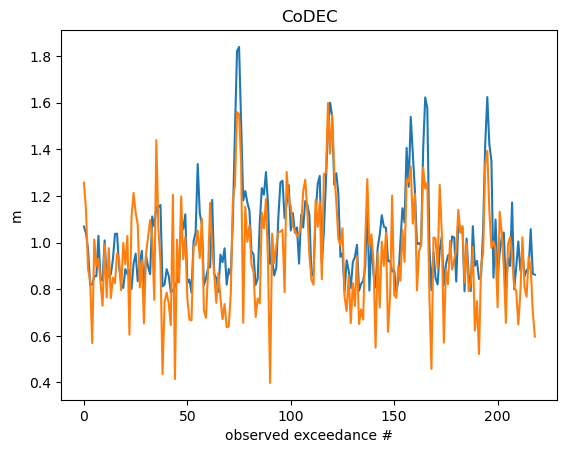

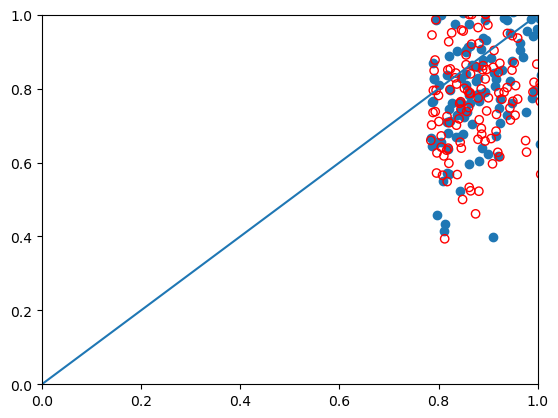

In [11]:
plt.figure()
plt.plot(y_true[y_true_exceedances])
plt.plot(surge_codec.surge.values[y_true_exceedances])
plt.title('CoDEC')
plt.ylabel('m')
plt.xlabel('observed exceedance #')

plt.figure()
plt.scatter(y_true[y_true_exceedances],surge_codec.surge.values[y_true_exceedances])
plt.scatter(out_ds.o.sel(split=split).where(out_ds.o.sel(split=split)>tr,drop=True).isel(i=i).values,out_ds.yhat.sel(split=split).where(out_ds.o.sel(split=split)>tr,drop=True).isel(i=i).values,facecolor='None',edgecolor='red')
plt.ylim([0,1])
plt.xlim([0,1])
plt.plot([0,1],[0,1])

Code for preparing input data before looping over runs:

```python

    '''
    #pre-generate input data for each n_steps (on which the input data depends)
    
    input_dict = {}
    for n in n_steps:

        #generate splits
        #idx_train,idx_val,idx_test,x_train,x_val,x_test,y_train,y_val,y_test = split_predictand_and_predictors_chronological(predictand,predictors,split_fractions,n)
        idx_train,idx_val,idx_test,x_train,x_val,x_test,y_train,y_val,y_test = split_predictand_and_predictors_stratified_years(predictand,predictors,split_fractions,n,7,seed=0,how='amax')

        #standardize the input based on the mean & sd of the train split
        y_train,y_val,y_test,y_train_mean,y_train_sd = standardize_predictand_splits(y_train,y_val,y_test,output_transform = True)
        x_train,x_val,x_test = standardize_predictor_splits(x_train,x_val,x_test)
     
        #x_train, x_val, x_test = [stack_predictors_for_lstm(k,var_names) for k in [x_train,x_val,x_test]] #stack all predictor variables at each grid cell for LSTM input
        x_train, x_val, x_test = [stack_predictors_for_convlstm(k,var_names) for k in [x_train,x_val,x_test]] #stack all predictor variables at each grid cell for LSTM input

        w_train,w_val = [get_denseloss_weights(k, alpha = alpha ) for k in [y_train,y_val]] #generate DenseLoss weights for train & val splits   
        
        #OR
        
        #w = get_denseloss_weights(np.append(y_train,y_val), alpha = alpha ) #generate DenseLoss weights for train & val splits                             
        #w_train = w[0:len(y_train)]
        #w_val = w[len(y_train)::]

        #put all input into a dictionary to access later
        input_dict[n] = [idx_train,idx_val,idx_test, x_train,x_val,x_test,
                         y_train,y_val,y_test, y_train_mean,y_train_sd,
                         w_train,w_val]
    '''
```

Tensorflow pipeline:

```python
#get values & timestamps of observations to compare predictions with
o_val = y_train_sd * y_val[np.isfinite(y_val)][0:int(np.sum(np.isfinite(y_val))/batch_size)] + y_train_mean #back-transform observations val split
o_test = y_train_sd * y_test[np.isfinite(y_test)][0:int(np.sum(np.isfinite(y_val))/batch_size)] + y_train_mean #back-transform observations val split

t_val = predictand['date'].values[idx_val][np.isfinite(y_val)][0:int(np.sum(np.isfinite(y_val))/batch_size)]
t_test = predictand['date'].values[idx_test][np.isfinite(y_test)][0:int(np.sum(np.isfinite(y_val))/batch_size)]

#create windowed predictors, filter out timesteps with NaN observations & create batches:
if use_dl == False: #if not using weights
    z_train = create_batched_sequenced_datasets(x_train, y_train, this_n_steps, this_batch_size).cache() #cache() speeds up the training by loading in the data at epoch 0, but takes up a lot of memory
    z_val = create_batched_sequenced_datasets(x_val, y_val, this_n_steps, this_batch_size).cache()

    x_val_ds = z_val.map(lambda a, b : a) #unpack z_val for prediction

elif use_dl == True: #if using weights
    z_train = create_batched_sequenced_datasets(x_train, y_train, this_n_steps, this_batch_size, w_train).cache()
    z_val = create_batched_sequenced_datasets(x_val, y_val, this_n_steps, this_batch_size, w_val).cache()

    x_val_ds = z_val.map(lambda a, b, c: a) #unpack z_val for prediction

z_test = create_batched_sequenced_datasets(x_test, y_test, this_n_steps, this_batch_size) #to-do: z_test doesn't have to be batched?
x_test_ds = z_test.map(lambda a, b: a) #unpack z_test for prediction

history = model.fit(z_train,epochs=n_epochs,validation_data=z_val,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                            restore_best_weights=True)],verbose=0) #train model
            
#make predictions & back-transform
yhat_val = model.predict(x_val_ds,verbose=0).flatten()*y_train_sd + y_train_mean
yhat_test = model.predict(x_test_ds,verbose=0).flatten()*y_train_sd + y_train_mean
```